In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,24700.0,24700.0,24700.0,36 months,11.99%,820.28,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,35000.0,35000.0,35000.0,60 months,14.85%,829.90,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3600.0,3600.0,3600.0,36 months,13.99%,123.03,C,C4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10400.0,10400.0,10400.0,60 months,22.45%,289.91,F,F1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,20000.0,20000.0,20000.0,60 months,10.78%,432.66,B,B4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)

# cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
52
next_pymnt_d
6
last_credit_pull_d
53
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
27
hardship_end_date
28
payment_plan_start_date
28
hardship_loan_status
4
debt_settlement_flag
2
debt_settlement_flag_date
45
settlement_status
3
settlement_date
48


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421092,NaN,NaN,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421093,NaN,NaN,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421094,NaN,NaN,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [9]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,settlement_date_Nov-2017,settlement_date_Nov-2018,settlement_date_Oct-2015,settlement_date_Oct-2016,settlement_date_Oct-2017,settlement_date_Oct-2018,settlement_date_Sep-2015,settlement_date_Sep-2016,settlement_date_Sep-2017,settlement_date_Sep-2018
0,NaN,NaN,24700.0,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,35000.0,35000.0,35000.0,14.85,829.90,110000.0,17.06,0.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,3600.0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,10400.0,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,20000.0,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,...,0,0,0,0,0,0,0,0,0,0
5,NaN,NaN,11950.0,11950.0,11950.0,13.44,405.18,34000.0,10.20,0.0,...,0,0,0,0,0,0,0,0,0,0
6,NaN,NaN,16000.0,16000.0,16000.0,12.88,363.07,70000.0,26.40,0.0,...,0,0,0,0,0,0,0,0,0,0
7,NaN,NaN,20000.0,20000.0,20000.0,9.17,637.58,180000.0,14.67,0.0,...,0,0,0,0,0,0,0,0,0,0
8,NaN,NaN,1400.0,1400.0,1400.0,12.88,47.10,64000.0,34.95,0.0,...,0,0,0,0,0,0,0,0,0,0
9,NaN,NaN,18000.0,18000.0,18000.0,19.48,471.70,150000.0,9.39,0.0,...,0,0,0,0,0,0,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [10]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

In [11]:
rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [74]:
X.shape

(421095, 453)

In [75]:
initial_cross_validation = cross_val_score(rfc, X, Y, cv=10)
print(initial_cross_validation)

[0.9899081  0.99100019 0.99204483 0.99368321 0.99318435 0.99327935
 0.99223425 0.99344543 0.99339793 0.9938965 ]


The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns

### RFC Feature Importance for Feature Selection

In [14]:
rfc.fit(X,Y)
feature_importance = rfc.feature_importances_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
# By removing all features with a feature importance greater than 0, we remove 64 of 453 features, leaving us with 396 features.
X.columns[feature_importance > 0]

# By removing all features less than the average importance, we only have 28 remaining features.
new_X = X[X.columns[feature_importance > feature_importance.mean()]]

In [17]:
new_X.shape

(421095, 29)

In [16]:
# This cell still takes a while to load: timed at 2.5 minutes
new_X
Y = y2015['loan_status']

# Running random forest with 29 most important features (according to built-in function)
second_cross_validation = cross_val_score(rfc, new_X, Y, cv=10)
print(second_cross_validation)

[0.99529836 0.995322   0.99601054 0.99627167 0.99650906 0.99582037
 0.99641398 0.9961765  0.99629524 0.99615266]


In [18]:
second_cross_validation.mean()

0.9960270387300388

Limiting our model to 29 features still provides incredibly accurate results at 99.6% (and slow processing time). Considering we are well above the 90% threshold, we still have the freedom to remove more features.

### PCA for Feature Selection

In [31]:
n_component_tests = [1,2,3,4,5]
for n in n_component_tests:
    sklearn_pca = PCA(n_components=n)
    model = sklearn_pca.fit(new_X)
    print(
        'N = ' + str(n) + ' explains the following percentage of total variance:\n',
        sklearn_pca.explained_variance_ratio_.sum()
    )

N = 1 explains the following percentage of total variance:
 0.5415044194562644
N = 2 explains the following percentage of total variance:
 0.7921238536196211
N = 3 explains the following percentage of total variance:
 0.9408338899647771
N = 4 explains the following percentage of total variance:
 0.9721228668224249
N = 5 explains the following percentage of total variance:
 0.989382603885663


In [32]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(new_X)

principal_df = pd.DataFrame(data = principalComponents, columns = ['PC_1', 'PC_2','PC_3'])

In [33]:
# This cell also takes a while to load: timed at 3.5 minutes
newer_X = principal_df
Y = y2015['loan_status']

# Running random forest with 3 most important features (according to PCA)
third_cross_validation = cross_val_score(rfc, newer_X, Y, cv=10)
print(third_cross_validation)

[0.66411797 0.66486987 0.66870889 0.66696747 0.66567717 0.66672208
 0.66129952 0.66286691 0.66125202 0.66065025]


In [34]:
third_cross_validation.mean()

0.6643132139262755

The results are not satisfactorily accurate. However, they do affirm that these three features are by far the most informative.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


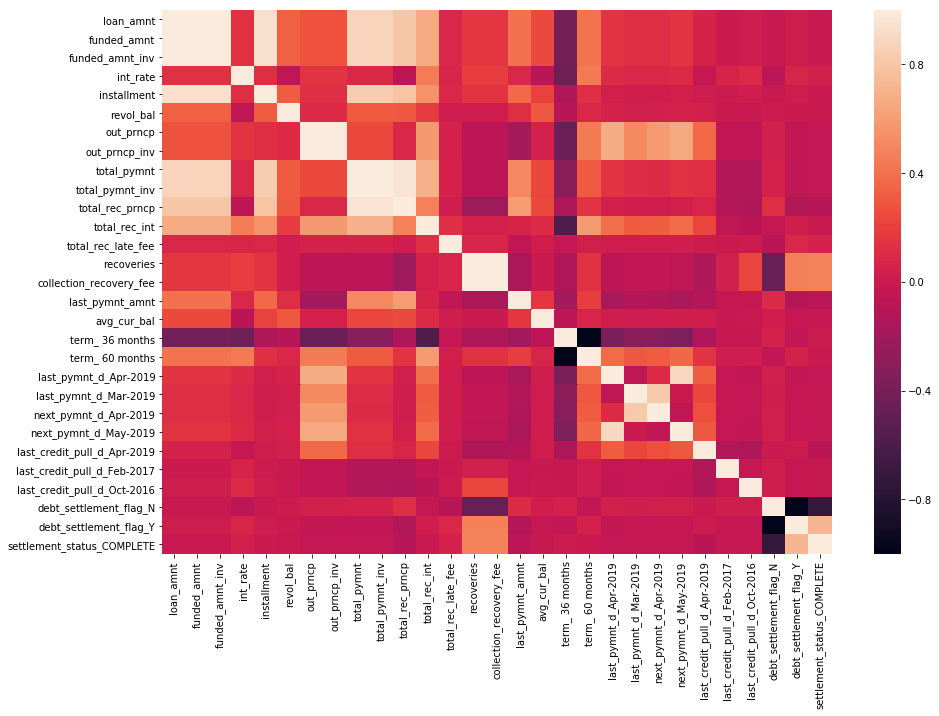

In [45]:
plt.figure(figsize=(15,10))

corr_matrix_df = new_X
corr_matrix_df['target'] = y2015['loan_status']
sns.heatmap(corr_matrix_df.corr())

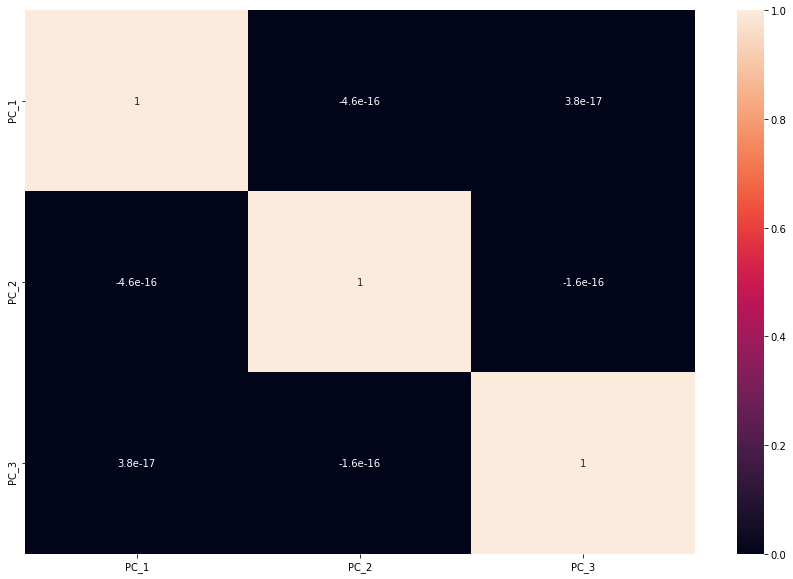

In [48]:
plt.figure(figsize=(15,10))

corr_matrix_df_2 = newer_X
corr_matrix_df_2['target'] = y2015['loan_status']
sns.heatmap(corr_matrix_df_2.corr(), annot=True)

There appear to be high correlations between some of the top 29 features - and nonexistent correlations between the top 3. However, instead of laboriously grouping highly correlated features, let's see if we can simply find a happy medium between 3 features and 29 features.

In [56]:
new_X = new_X.drop('target',axis=1)
new_X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,last_pymnt_d_Apr-2019,last_pymnt_d_Mar-2019,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,last_credit_pull_d_Apr-2019,last_credit_pull_d_Feb-2017,last_credit_pull_d_Oct-2016,debt_settlement_flag_N,debt_settlement_flag_Y,settlement_status_COMPLETE
0,24700.0,24700.0,24700.0,11.99,820.28,21470.0,0.00,0.00,25679.660000,25679.66,...,0,0,0,0,1,0,0,1,0,0
1,35000.0,35000.0,35000.0,14.85,829.90,7802.0,15264.49,15264.49,32293.910000,32293.91,...,1,0,1,0,1,0,0,1,0,0
2,3600.0,3600.0,3600.0,13.99,123.03,2765.0,0.00,0.00,4421.723917,4421.72,...,0,0,0,0,1,0,0,1,0,0
3,10400.0,10400.0,10400.0,22.45,289.91,21929.0,0.00,0.00,11740.500000,11740.50,...,0,0,0,0,0,0,0,1,0,0
4,20000.0,20000.0,20000.0,10.78,432.66,7869.0,0.00,0.00,22705.924294,22705.92,...,0,0,0,0,0,0,0,1,0,0


In [68]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(new_X)

principal_df_5 = pd.DataFrame(data = principalComponents)

In [69]:
# This cell also takes a while to load: timed at 3.5 minutes
newest_X = principal_df_5
Y = y2015['loan_status']

# Running random forest with 5 most important features (according to PCA)
fourth_cross_validation = cross_val_score(rfc, newest_X, Y, cv=10)
print(fourth_cross_validation)

[0.98188208 0.98670213 0.98798414 0.98722394 0.98719989 0.98643995
 0.98570343 0.98527596 0.98349482 0.97955209]


In [70]:
fourth_cross_validation.mean()

0.9851458423412687

Surprisingly, when limited to the top 5 features according to PCA, the algorithm performed exceedingly well with a mean score of 98.5%. Therefore, the minimum amount of features while still maintaining an accuracy score greater than 90% is either 4 or 5. Let's test it with 4 features now!

In [71]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(new_X)

principal_df_4 = pd.DataFrame(data = principalComponents)

In [72]:
newerest_X = principal_df_4
Y = y2015['loan_status']

# Running random forest with 4 most important features (according to PCA)
fifth_cross_validation = cross_val_score(rfc, newerest_X, Y, cv=10)
print(fifth_cross_validation)

[0.92016717 0.94735467 0.95471492 0.95571123 0.95559144 0.95787124
 0.95627909 0.95566163 0.95060321 0.91842212]


In [73]:
fifth_cross_validation.mean()

0.9472376725032541

After trial-and-error, the answer is: the original dataset of 453 variables can be reduced to **four** features without compromising the accuracy threshold of 90%.

### Removing Two Most Valuable Features While Attempting to Maintain High Accuracy

In [77]:
selective = X.drop(['total_pymnt','out_prncp'],1)
sklearn_pca = PCA(n_components=10)
selective_features = sklearn_pca.fit_transform(selective)

cross_val_score(rfc, selective_features, Y, cv=10)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

array([0.70106618, 0.69970555, 0.6994372 , 0.70137735, 0.69989788,
       0.69918545, 0.69970077, 0.6938824 , 0.69813337, 0.69629753])

In [78]:
n_component_tests = [1,2,5,10,15,20,30,200]
for n in n_component_tests:
    sklearn_pca = PCA(n_components=n)
    model = sklearn_pca.fit(selective)
    print(
        'N = ' + str(n) + ' explains the following percentage of total variance:\n',
        sklearn_pca.explained_variance_ratio_.sum()
    )

N = 1 explains the following percentage of total variance:
 0.8382869318993613
N = 2 explains the following percentage of total variance:
 0.9073598443090382
N = 5 explains the following percentage of total variance:
 0.9876419982935503
N = 10 explains the following percentage of total variance:
 0.998875503452707
N = 15 explains the following percentage of total variance:
 0.9999799527444309
N = 20 explains the following percentage of total variance:
 0.9999999814172356
N = 30 explains the following percentage of total variance:
 0.9999999994588958
N = 200 explains the following percentage of total variance:
 0.9999999999989462


In [79]:
X = selective
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

In [80]:
cross_validation_selective = cross_val_score(rfc, X, Y, cv=10)
print(cross_validation_selective)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: F

[0.98769976 0.9897179  0.98955142 0.99221088 0.99240067 0.99149825
 0.99263798 0.99159305 0.99202052 0.9926378 ]


Even when excluding payment amount and outstanding principal, it is still possible to classify with Decision Tree Classifier without compromising on accuracy.